# Laboratorio #8
## Defensa contra el ataque de extracción
- Marco Ramírez
- Estuardo Hernández

## Preparación de la data para el ataque

In [10]:
# Importamos las librerías a utilizar
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from art.estimators.classification import KerasClassifier # No soporta TF 2
tf.compat.v1.disable_eager_execution()
import pandas as pd
import os
from PIL import Image
from keras.utils import image_dataset_from_directory
from art.attacks.extraction import CopycatCNN
from keras import models, layers
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix
import seaborn as sns
from art.defences.postprocessor import ReverseSigmoid

In [6]:
# Utilizamos las 939 imágenes que separamos para el ataque y creamos un dataframe
dir = "./random_imgs/"
imgs_location = './selected/selected'
data = []
for family in os.scandir(dir):
    if family.is_dir:
        for malware in os.scandir(family):
            width, height = Image.open(malware.path).size
            data.append({ 
                "name": malware.name, 
                "path": malware.path,
                "family": family.name,
                "width": width,
                "height": height,
            })
    

df = pd.DataFrame(data, columns=["name", "path", "family", "width", "height"])
df

,name,path,family,width,height
0,000e30a0819ac7ed931d629ce2ef8948.png,./random_imgs/Adialer.C\000e30a0819ac7ed931d62...,Adialer.C,512,409
1,002f06eff1d222560939be72583d6ae9.png,./random_imgs/Adialer.C\002f06eff1d222560939be...,Adialer.C,512,410
2,0046a83d932a3d431eb21a99b46d6af7.png,./random_imgs/Adialer.C\0046a83d932a3d431eb21a...,Adialer.C,512,409
3,01aa7da4d2709a0ceb69771fc837730c.png,./random_imgs/Adialer.C\01aa7da4d2709a0ceb6977...,Adialer.C,512,409
4,01fac2472eab8532d8f5951ff48637d4.png,./random_imgs/Adialer.C\01fac2472eab8532d8f595...,Adialer.C,512,410
...,...,...,...,...,...
934,07df93176f9eb61f1cb7a885d8829fbb.png,./random_imgs/Yuner.A\07df93176f9eb61f1cb7a885...,Yuner.A,768,683
935,08004d4675258aa177d07235eb0375ed.png,./random_imgs/Yuner.A\08004d4675258aa177d07235...,Yuner.A,768,683
936,0823d0fa9e21cee43174ecd9931846d4.png,./random_imgs/Yuner.A\0823d0fa9e21cee43174ecd9...,Yuner.A,768,683
937,0860ed8a40ea6a2acd816426da6ed1a9.png,./random_imgs/Yuner.A\0860ed8a40ea6a2acd816426...,Yuner.A,768,683


In [7]:
# Agrupamos por familia
def get_stratified_sample(df, amount, seed=12345):
    return df.groupby('family', as_index=False, group_keys=False) \
                .apply(lambda s: s.sample(min(amount, len(s)), random_state=seed))
df2 = get_stratified_sample(df, 100)

In [ ]:
# Extraemos el path de cada imagen a una carpeta
for _, row in df2.iterrows():
    os.makedirs(os.path.join(imgs_location, row['family']), exist_ok=True)
    os.symlink(os.path.abspath(row['path']), os.path.join(imgs_location, row['family'], row['name']))

In [8]:
# Dividir en entrenamiento y prueba
test_data = image_dataset_from_directory(
    imgs_location,
    image_size=(80, 80),
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=191919,
)


training_data = image_dataset_from_directory(
    imgs_location,
    image_size=(80, 80),
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=191919,
)

Found 672 files belonging to 25 classes.
Using 134 files for validation.
Found 672 files belonging to 25 classes.
Using 538 files for training.


## Ataque de extracción

In [9]:
# Cargamos el modelo
vulnerable_model = tf.keras.models.load_model("malware-class.h5")

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
# Utilizamos el KerasClassifier
clasificador = KerasClassifier(
    model=vulnerable_model,
)

In [15]:
# Crear la red neuronal que robará el modelo original
copycat_cnn = CopycatCNN(
    batch_size_fit=80,
    batch_size_query=80,
    nb_epochs=20,
    nb_stolen=20000,
    classifier=clasificador
    )

In [17]:
# Definimos un nuevo modelo
blank_model = models.Sequential([
  layers.Rescaling(1./255, input_shape=(80, 80, 3)),     # normalizacion
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(test_data.class_names), activation='softmax')
])

# Compilamos el modelo
blank_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [18]:
# Definimos el modelo robado
model_stolen = KerasClassifier(
    model=blank_model
)

In [19]:
# Agregamos etiquetas a cada imagen
training_labels = []
training_images = []
for image, label in tfds.as_numpy(training_data):
    training_labels.extend(label)
    training_images.extend(image)

In [21]:
# Extraemos el modelo robado entrenando el modelo referenciado
stolen_classifier = copycat_cnn.extract(
    x=np.array(training_images), 
    y=np.array(training_labels), 
    thieved_classifier=model_stolen
    )

c:\Users\xavih\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 538 samples
Epoch 1/20
538/538 [==============================] - 2s 4ms/sample - loss: 1.0611 - accuracy: 0.7695
Epoch 2/20
538/538 [==============================] - 2s 3ms/sample - loss: 0.4670 - accuracy: 0.8996
Epoch 3/20
538/538 [==============================] - 2s 3ms/sample - loss: 0.3457 - accuracy: 0.8996
Epoch 4/20
538/538 [==============================] - 2s 3ms/sample - loss: 0.2609 - accuracy: 0.9275
Epoch 5/20
538/538 [==============================] - 2s 3ms/sample - loss: 0.2054 - accuracy: 0.9405
Epoch 6/20
538/538 [==============================] - 2s 3ms/sample - loss: 0.1792 - accuracy: 0.9405
Epoch 7/20
538/538 [==============================] - 2s 3ms/sample - loss: 0.1277 - accuracy: 0.9665
Epoch 8/20
538/538 [==============================] - 2s 3ms/sample - loss: 0.1104 - accuracy: 0.9684
Epoch 9/20
538/538 [==============================] - 2s 3ms/sample - loss: 0.0896 - accuracy: 0.9758
Epoch 10/20
538/538 [==============================] - 2s 4ms

## Acá aplicamos la defensa contra el ataque

In [107]:
# Utilizamos el KerasClassifier
clasificador_def = KerasClassifier(
    model=vulnerable_model,
    postprocessing_defences=ReverseSigmoid( # Se agrega la capa de defensa
        beta = 1,
        gamma = 0.09,
    )
)

In [108]:
# Crear la red neuronal que robará el modelo original
copycat_cnn_def = CopycatCNN(
    batch_size_fit=80,
    batch_size_query=80,
    nb_epochs=20,
    nb_stolen=20000,
    classifier=clasificador_def
    )

In [109]:
# Extraemos el modelo robado entrenando el modelo referenciado
stolen_classifier_def = copycat_cnn_def.extract(
    x=np.array(training_images), 
    y=np.array(training_labels), 
    thieved_classifier=model_stolen
    )

Train on 538 samples
Epoch 1/20
538/538 [==============================] - 2s 3ms/sample - loss: 3.9479e-04 - accuracy: 1.0000
Epoch 2/20
538/538 [==============================] - 2s 3ms/sample - loss: 3.8753e-04 - accuracy: 1.0000
Epoch 3/20
538/538 [==============================] - 2s 3ms/sample - loss: 3.7845e-04 - accuracy: 1.0000
Epoch 4/20
538/538 [==============================] - 2s 3ms/sample - loss: 3.7260e-04 - accuracy: 1.0000
Epoch 5/20
538/538 [==============================] - 2s 3ms/sample - loss: 3.6519e-04 - accuracy: 1.0000
Epoch 6/20
538/538 [==============================] - 2s 3ms/sample - loss: 3.5822e-04 - accuracy: 1.0000
Epoch 7/20
538/538 [==============================] - 2s 3ms/sample - loss: 3.5204e-04 - accuracy: 1.0000
Epoch 8/20
538/538 [==============================] - 1s 3ms/sample - loss: 3.4565e-04 - accuracy: 1.0000
Epoch 9/20
538/538 [==============================] - 2s 3ms/sample - loss: 3.3925e-04 - accuracy: 1.0000
Epoch 10/20
538/538 [====

### Coparación entre el modelo robado sin defender vs el modelo robado con defensa implementada

In [27]:
# Predecimos las labels utilizando ambos modelos con las imagenes de test
# Primero el modelo robado sin defender
stolen_probabilities = []
stolen_true_labels = []

test_images, test_labels = zip(*tfds.as_numpy(test_data))
for img_batch, label_batch in zip(test_images, test_labels):
    probability_batch = stolen_classifier.predict(img_batch)
    stolen_probabilities.extend(probability_batch)
    stolen_true_labels.extend(label_batch)

stolen_probabilities = np.array(stolen_probabilities)
stolen_true_labels = np.array(stolen_true_labels)

stolen_predicted_labels = np.argmax(stolen_probabilities, axis=-1)

In [110]:
# Ahora el modelo robado con la capa de defensa
stolen_probabilities_def = []
stolen_true_labels_def = []

for img_batch, label_batch in zip(test_images, test_labels):
    probability_batch = stolen_classifier_def.predict(img_batch)
    stolen_probabilities_def.extend(probability_batch)
    stolen_true_labels_def.extend(label_batch)

stolen_probabilities_def = np.array(stolen_probabilities_def)
stolen_true_labels_def = np.array(stolen_true_labels_def)

stolen_predicted_labels_def = np.argmax(stolen_probabilities_def, axis=-1)

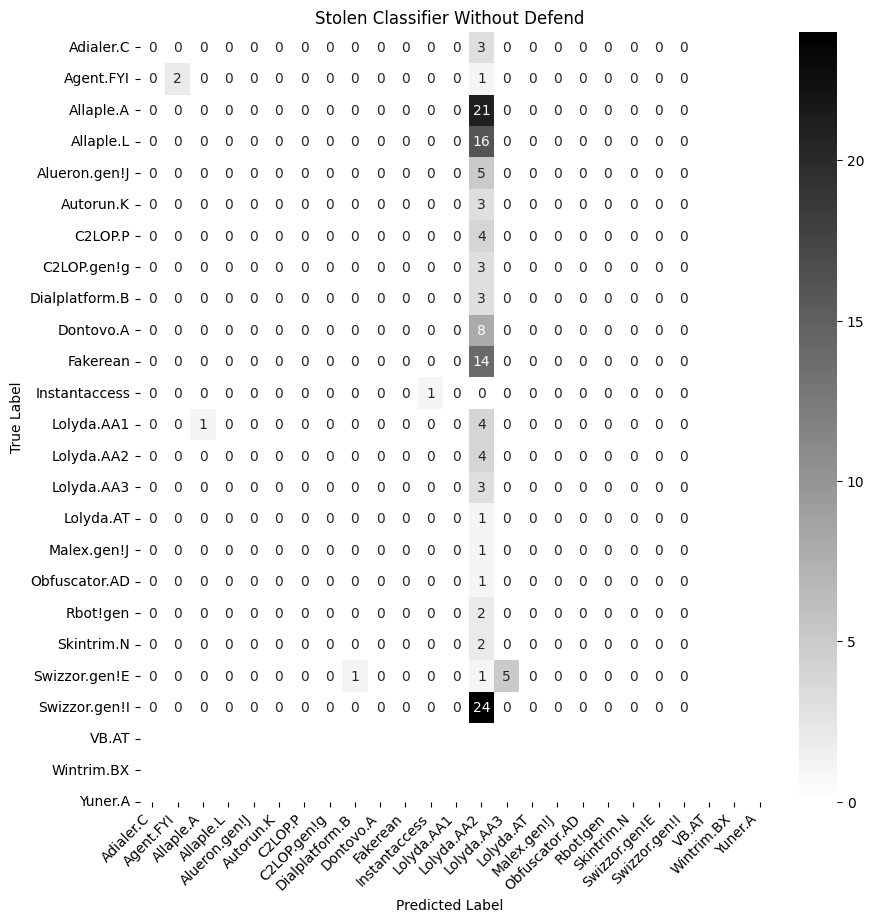

In [29]:
# Comparamos utilizando una matriz de confusion del modelo robado sin defender
cm = confusion_matrix(stolen_true_labels, stolen_predicted_labels)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='binary', cbar=True, xticklabels=test_data.class_names, yticklabels=test_data.class_names)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Stolen Classifier Without Defend')
plt.show()

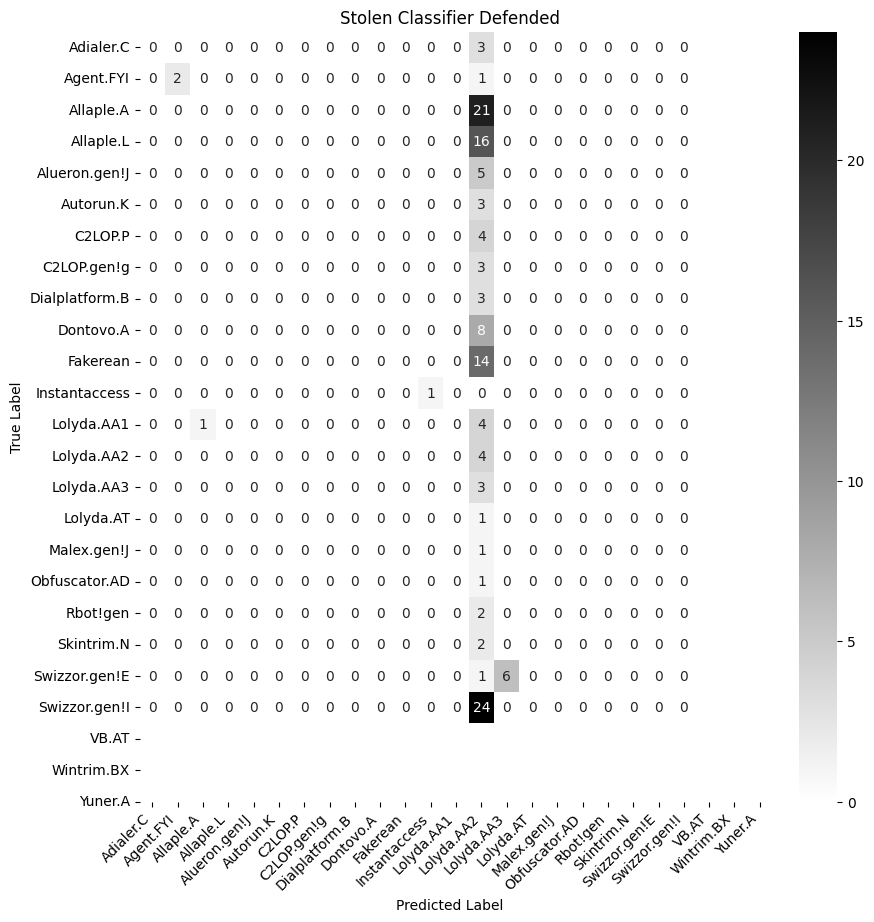

In [111]:
# Ahora la matriz de confusion del modelo robado con defensa
cm = confusion_matrix(stolen_true_labels_def, stolen_predicted_labels_def)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='binary', cbar=True, xticklabels=test_data.class_names, yticklabels=test_data.class_names)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Stolen Classifier Defended')
plt.show()

Vemos que ambos clasifican de manera muy similar, sin embargo el modelo robado del modelo con la capa de defensa implementada, clasifica unas cuantas imagenes de peor manera, por lo que la capa de defensa tuvo un pequeño impacto a la hora de robar el modelo.